# Why are Workers `put()`/`get()`ing the same segment coordinates?

This is a 4 hour run with delay set to 1M; the configs are here: [[ps-config.xml](../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/input/ps-config.xml), [input.slurm](../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/scale-length/parsplice-hr4)]

- **Figure 1 (WM get/sec)**: the work manager (WM) receives 900 `get()`s per second (`y1` axis) but it's only to a small number of unique keys (`y2` axis). Are workers reading the same key over and over?

- **Figure 2 (2 Ws get/sec)**: looking at only 2 workers (Ws) we see that they are doing `get()` to the same key for almost a minute. This would make sense if the data was changing...

- **Figure 3 (WM total puts)**: ... but it doesn't look like the data is changing. Looking at the `put()`s, we see that it is putting the same key over and over. The logic in [STL put](https://gitlab.com/mikesevilla3/parsplice/blob/trinitite-nanoparticle-nospawn/core/LocalStore.cpp#L532) says that if the key already exists, don't put it again. So Ws are writing keys that already exist over and over and the WM is ignoring them.

- **Figure 4 (WM keys)**: this shows the actual `put()`s that make it into the in-memory DB; it is way smaller.

Questions:
1. Should Ws be putting the same key over and over if the WM just ignores them? It looks like this behavior only happens at the beginning -- does this relate to what you said about Ws computing the same segment at the beginning?
2. Why do Ws read the same key over and over? Don't they remember?
3. More workers will cause more DB activity, right?

In [1]:
from redundant_ops import *
%matplotlib inline

In [2]:
dfs = {}   # global data structure with parsed data
parse(dfs, "4 Hour", "../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/")
parse(dfs, "4 Hour", "../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/")
parse_workerops(dfs, "4 Hour", "../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/")
frame = parse_perfcounters("../experiments/baseline-trinitite/nano/parmsweep/scale-length-hr4-59971/")

... DONE! ... DONE! ... DONE! ... DONE!


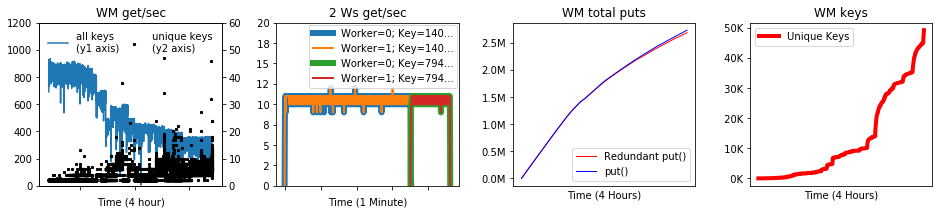

In [3]:
fig, ax = plt.subplots(1, 4, figsize=(16, 3))
fig.subplots_adjust(wspace=0.3)
plot_uniquekeys_per_ts(ax[0], dfs, ("4 Hour", "DBMemoryGet", "4"))
plot_uniquekeys_per_worker(ax[1], dfs, ("4 Hour", "WGetMINIMA", "1"))
plot_redundant_puts(ax[2], frame)
plot_uniquekeys_puts(ax[3], frame)